# Import Statements-

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense,Input,Dropout,Flatten
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.utils import shuffle

# Creating data

In [ ]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt

# Number of clients
num_clients = 10000  # Service count

# Generate random data for service provider
data_provider = {
    'Service_provider_ID': range(1, num_clients + 1),
    'algorithm': np.random.choice(['CNN', 'ANN', 'DNN'], size=num_clients),
    'GPU': np.random.choice([4, 10], size=num_clients),
    'CPU': np.random.choice([4, 10], size=num_clients),
    'STORAGE': np.random.randint(1, 10, size=num_clients),
    'MODALITY': np.random.choice(['text', 'image', 'sensor', 'audio'], size=num_clients),
    'accuracy': np.random.uniform(0.8, 0.99, size=num_clients),
    'Security': np.random.choice(['High', 'Medium', 'Advanced'], size=num_clients)
}

# Generate random data for client query
data_client = {
    'client_query': range(1, num_clients + 1),
    'Q_algorithm_preference': np.random.choice(['CNN', 'ANN', 'DNN'], size=num_clients),
    'Q_Modality_preferences': np.random.choice(['text', 'image', 'sensor', 'audio'], size=num_clients),
    'Q_Security_Requirements': np.random.choice(['High', 'Medium', 'Advanced'], size=num_clients),
    'C_accuracy': np.random.uniform(0.6, 0.75, size=num_clients),
}

# Create DataFrames for service provider and client query
df_provider = pd.DataFrame(data_provider)
df_client = pd.DataFrame(data_client)

# Add column for accuracy_preference (always greater than accuracy) to client query
df_client['T_accuracy'] = np.random.uniform(data_client['C_accuracy'].max(), 1, size=num_clients)
df_provider.to_csv("provider.csv")
df_client.to_csv("client.csv")

**Import CSV**
---

In [ ]:
df_provider=pd.read_csv("MLaaS_provider.csv")
df_client=pd.read_csv("Client_query.csv")

In [ ]:
df_client.shape

(10000, 7)

In [ ]:
df_provider.shape

(10000, 9)

In [ ]:
df_providerh=df_provider[:1000]
df_providerg=df_provider[:500]

In [ ]:
df_clienth=df_client[:1000]
df_clientg=df_client[:250]

**Heuristic match**
---

In [ ]:
def heuristic_match(service, query):
    """
    A heuristic function that calculates a match score between a service and a query.
    Higher scores indicate a better match. The function considers accuracy difference,
    modality, algorithm, and security requirements for scoring.

    """
    score = 0

    # Adjust the score based on the accuracy difference
    accuracy_difference = service["accuracy"] - query["C_accuracy"]
    accuracy_difference = accuracy_difference * 100
    if accuracy_difference > 0:
        # Apply a penalty for not meeting the accuracy requirement
        score += accuracy_difference
    # Else, do not add to score because service meets or exceeds accuracy requirement

    # Reward matches in preferences by increasing the score
    if service["MODALITY"] == query["Q_Modality_preferences"]:
        score += 10  # Increase score for a match
    if service["algorithm"] == query["Q_algorithm_preference"]:
        score += 10
    if service["Security"] == query["Q_Security_Requirements"]:
        score += 10

    return score

def find_best_services(df_provider, df_client):
    """
    Finds the best service for each client query based on the heuristic score.
    Returns a DataFrame of client queries and their matched service providers.
    """
    matches = []

    for _, query in df_client.iterrows():
        # Filter service providers based on heuristic criteria
        filtered_providers = df_provider[
            (df_provider['MODALITY'] == query['Q_Modality_preferences']) &
            (df_provider['algorithm'] == query['Q_algorithm_preference']) &
            (df_provider['Security'] == query['Q_Security_Requirements'])
        ]

        for _, service in filtered_providers.iterrows():
            score = heuristic_match(service, query)
            matches.append((query['client_query'], service['Service_provider_ID'], score))

    # Return results as a DataFrame
    return pd.DataFrame(matches, columns=['Client_Query_ID', 'Best_Service_Provider_ID', 'Score'])

# Assuming df_provider and df_client are already defined
best_matches_df = find_best_services(df_provider, df_client)

print(best_matches_df.head())
print(f"Total number of matches: {len(best_matches_df)}")


   Client_Query_ID  Best_Service_Provider_ID      Score
0                1                        22  55.373788
1                1                        38  51.258521
2                1                        64  52.269787
3                1                        70  58.919336
4                1                       141  46.143823
Total number of matches: 2777386


In [ ]:
df=best_matches_df

In [ ]:
# Create a new DataFrame with counts of Best_Service_Provider_ID for each Client_Query_ID
counts_df = df.groupby('Client_Query_ID')['Best_Service_Provider_ID'].count().reset_index()
counts_df.columns = ['Client_Query_ID', 'Best_Service_Provider_Count']

# Fill missing Client_Query_ID with 0 count
full_counts_df = pd.DataFrame({'Client_Query_ID': range(1, 1000)})
full_counts_df = full_counts_df.merge(counts_df, on='Client_Query_ID', how='left')
full_counts_df['Best_Service_Provider_Count'].fillna(0, inplace=True)

print(full_counts_df.head())

   Client_Query_ID  Best_Service_Provider_Count
0                1                          283
1                2                          272
2                3                          301
3                4                          272
4                5                          226


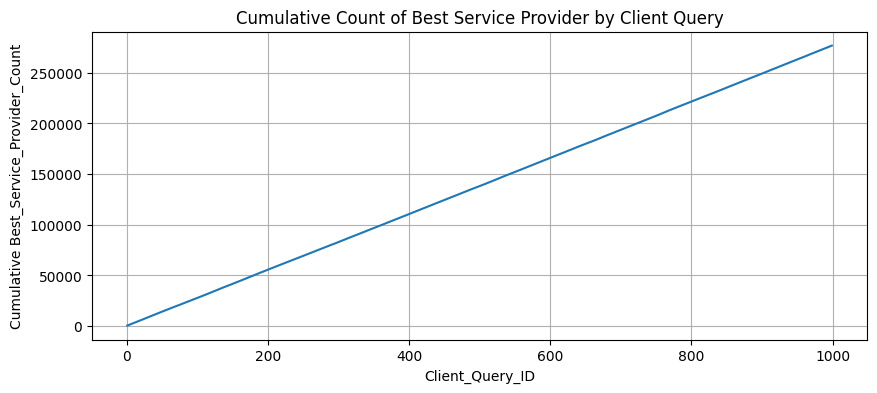

In [ ]:
full_counts_df['Cumulative_Count'] = full_counts_df['Best_Service_Provider_Count'].cumsum()
# Plotting
plt.figure(figsize=(10, 4))
plt.plot(full_counts_df['Client_Query_ID'], full_counts_df['Cumulative_Count'])
plt.xlabel('Client_Query_ID')
plt.ylabel('Cumulative Best_Service_Provider_Count')
plt.title('Cumulative Count of Best Service Provider by Client Query')
plt.grid(True)
plt.show()

In [ ]:
df_provider

,Unnamed: 0,Service_provider_ID,algorithm,GPU,CPU,STORAGE,MODALITY,accuracy,Security
0,0,1,ANN,10,4,9,image,0.869465,Advanced
1,1,2,ANN,4,10,3,text,0.869378,Medium
2,2,3,CNN,10,10,8,sensor,0.980894,High
3,3,4,DNN,4,4,2,image,0.881068,High
4,4,5,CNN,10,10,3,image,0.930814,Medium
...,...,...,...,...,...,...,...,...,...
9995,9995,9996,ANN,10,10,2,audio,0.984033,Advanced
9996,9996,9997,DNN,4,10,7,text,0.936730,High
9997,9997,9998,ANN,10,10,4,audio,0.849096,Advanced
9998,9998,9999,ANN,4,4,6,image,0.856313,High


In [ ]:
df_clienth

,Unnamed: 0,client_query,Q_algorithm_preference,Q_Modality_preferences,Q_Security_Requirements,C_accuracy,T_accuracy
0,0,1,ANN,text,High,0.692487,0.933793
1,1,2,DNN,image,Advanced,0.717231,0.815074
2,2,3,DNN,image,Medium,0.719507,0.816188
3,3,4,DNN,image,Advanced,0.650300,0.874492
4,4,5,ANN,audio,High,0.651981,0.758709
...,...,...,...,...,...,...,...
995,995,996,DNN,sensor,High,0.606896,0.891342
996,996,997,CNN,text,Medium,0.631122,0.880411
997,997,998,DNN,image,Medium,0.664932,0.839954
998,998,999,CNN,audio,Medium,0.630860,0.783914


**Greedy Algorithm**
---

In [ ]:
import pandas as pd
import numpy as np
import time

def calculate_average_accuracy(df_client, df_provider):
    # Create an empty DataFrame to store the results
    results = []

    # Start timing the function
    start_time = time.time()

    # Iterate over each client query
    for _, client_row in df_client.iterrows():
        client_query = client_row['client_query']
        c_accuracy = client_row['C_accuracy']

        # Iterate over each service provider
        for _, provider_row in df_provider.iterrows():
            service_provider_ID = provider_row['Service_provider_ID']
            accuracy = provider_row['accuracy']

            # Calculate the average accuracy
            average_accuracy = (c_accuracy + accuracy) / 2

            # Append the result to the list
            results.append({
                'client_query': client_query,
                'Service_provider_ID': service_provider_ID,
                'average_accuracy': average_accuracy
            })

    # Convert the list of results into a DataFrame
    result_df1 = pd.DataFrame(results)
    return result_df1

# Test the function
result_df1 = calculate_average_accuracy(df_clientg, df_providerg)
print(result_df1)

        client_query  Service_provider_ID  average_accuracy
0                  1                    1          0.780976
1                  1                    2          0.780933
2                  1                    3          0.836691
3                  1                    4          0.786778
4                  1                    5          0.811651
...              ...                  ...               ...
124995           250                  496          0.753331
124996           250                  497          0.844927
124997           250                  498          0.759551
124998           250                  499          0.816391
124999           250                  500          0.774453

[125000 rows x 3 columns]


In [ ]:
def select_top_5_percent(result_df):
    # Create an empty DataFrame to store the selected top 5% results
    top_5_percent_df = pd.DataFrame()

    # Iterate over unique client queries
    for client_query in result_df['client_query'].unique():
        # Select rows corresponding to the current client query
        client_df = result_df[result_df['client_query'] == client_query]

        # Calculate the number of rows to select (5% of the total)
        num_rows_to_select = max(1, int(len(client_df) * 0.01))

        # Sort the DataFrame based on average_accuracy and select the top 5%
        top_5_percent_client_df = client_df.nlargest(num_rows_to_select, 'average_accuracy')

        # Append the selected rows to the top 5% DataFrame
        top_5_percent_df = pd.concat([top_5_percent_df, top_5_percent_client_df])

    return top_5_percent_df

# Test the function
top_5_percent_df = select_top_5_percent(result_df1)
print(top_5_percent_df)

        client_query  Service_provider_ID  average_accuracy
95                 1                   96          0.841133
227                1                  228          0.841057
430                1                  431          0.840932
150                1                  151          0.840355
407                1                  408          0.840241
...              ...                  ...               ...
124595           250                   96          0.847161
124727           250                  228          0.847085
124930           250                  431          0.846960
124650           250                  151          0.846383
124907           250                  408          0.846270

[1250 rows x 3 columns]


In [ ]:
df=top_5_percent_df
df

,client_query,Service_provider_ID,average_accuracy
95,1,96,0.841133
227,1,228,0.841057
430,1,431,0.840932
150,1,151,0.840355
407,1,408,0.840241
...,...,...,...
124595,250,96,0.847161
124727,250,228,0.847085
124930,250,431,0.846960
124650,250,151,0.846383


In [ ]:
import pandas as pd

# Assuming you have the DataFrame named df with the provided data

# Count occurrences of Service_provider_ID for each client_query
service_provider_counts = df.groupby('client_query')['Service_provider_ID'].sum().reset_index()
# Create a DataFrame with client IDs running from 1 to 1000
client_ids = pd.DataFrame({'client_query': range(1, 250)})

# Merge client IDs DataFrame with service_provider_counts DataFrame
result_df2 = pd.merge(client_ids, service_provider_counts, on='client_query', how='left')

print(result_df2)



     client_query  Service_provider_ID
0               1                 1314
1               2                 1314
2               3                 1314
3               4                 1314
4               5                 1314
..            ...                  ...
244           245                 1314
245           246                 1314
246           247                 1314
247           248                 1314
248           249                 1314

[249 rows x 2 columns]


In [ ]:
df2=result_df2

In [ ]:
df2

,client_query,Service_provider_ID
0,1,1314
1,2,1314
2,3,1314
3,4,1314
4,5,1314
...,...,...
244,245,1314
245,246,1314
246,247,1314
247,248,1314


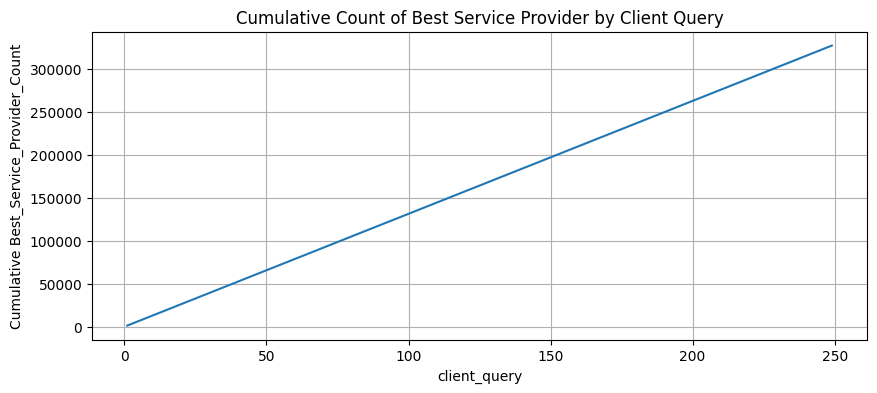

In [ ]:
df2['Cumulative_Count'] = df2['Service_provider_ID'].cumsum()

# Plotting
plt.figure(figsize=(10, 4))
plt.plot(df2['client_query'], df2['Cumulative_Count'])
plt.xlabel('client_query')
plt.ylabel('Cumulative Best_Service_Provider_Count')
plt.title('Cumulative Count of Best Service Provider by Client Query')
plt.grid(True)
plt.show()

In [ ]:
df2

,client_query,Service_provider_ID,Cumulative_Count
0,1,1314,1314
1,2,1314,2628
2,3,1314,3942
3,4,1314,5256
4,5,1314,6570
...,...,...,...
244,245,1314,321930
245,246,1314,323244
246,247,1314,324558
247,248,1314,325872


In [ ]:
full_counts_df1=full_counts_df[:100]
full_counts_df2=full_counts_df[:149]
full_counts_df3=full_counts_df[:249]

In [ ]:
full_counts_df2

,Client_Query_ID,Best_Service_Provider_Count,Cumulative_Count
0,1,283,283
1,2,272,555
2,3,301,856
3,4,272,1128
4,5,226,1354
...,...,...,...
144,145,277,40095
145,146,299,40394
146,147,250,40644
147,148,261,40905


In [ ]:
dfc1=df2[:100]
dfc2=df2[:149]
dfc3=df2[:249]

In [ ]:
dfc1

,client_query,Service_provider_ID,Cumulative_Count
0,1,1314,1314
1,2,1314,2628
2,3,1314,3942
3,4,1314,5256
4,5,1314,6570
...,...,...,...
95,96,1314,126144
96,97,1314,127458
97,98,1314,128772
98,99,1314,130086


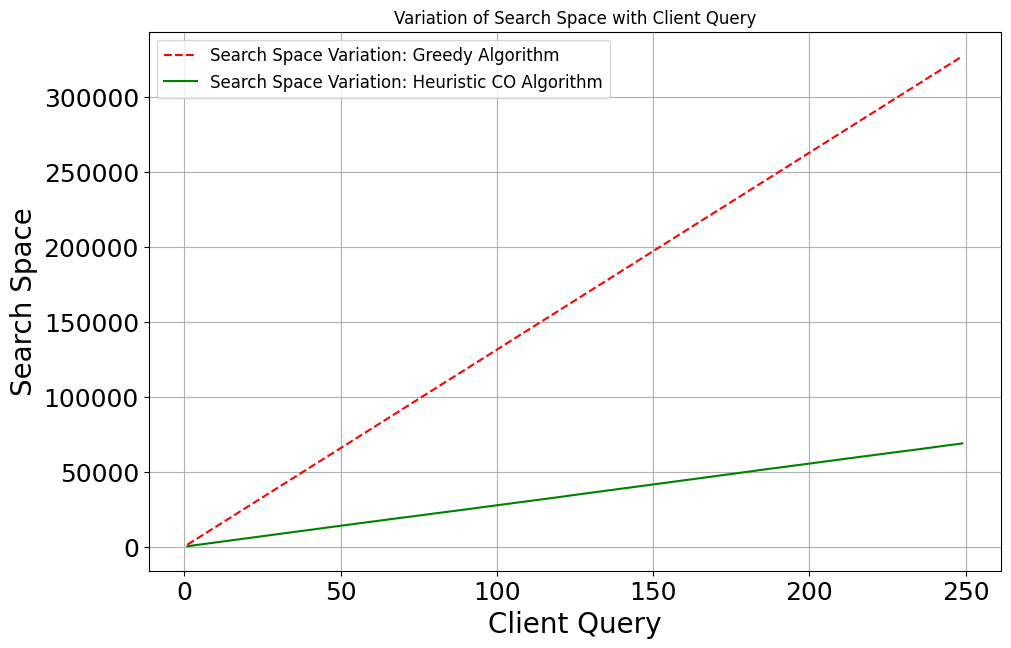

In [ ]:
# Selecting the required columns from result_df and result_df1
client_query = full_counts_df3['Client_Query_ID']
cumulative_execution_time = full_counts_df3['Cumulative_Count'].round()
cumulative_execution_time_greedy_model = dfc3['Cumulative_Count'].round()

plt.figure(figsize=(11, 7))

# Plot data for Model 1
plt.plot(client_query, cumulative_execution_time_greedy_model, linestyle='--', label='Search Space Variation: Greedy Algorithm', color='red')

# Plot data for Model 2
plt.plot(client_query, cumulative_execution_time, linestyle='-',label='Search Space Variation: Heuristic CO Algorithm', color='green')
plt.title('Variation of Search Space with Client Query')
# Adding labels and title with increased font size
plt.xlabel('Client Query', fontsize=20)
plt.ylabel('Search Space', fontsize=20)
#plt.title('Accuracy vs. Epoch for Different Models', fontsize=16)

# Increasing font size of x-axis ticks
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
# Adding legend
plt.legend(fontsize='large')

# Display the plot
plt.grid(True)
plt.show()


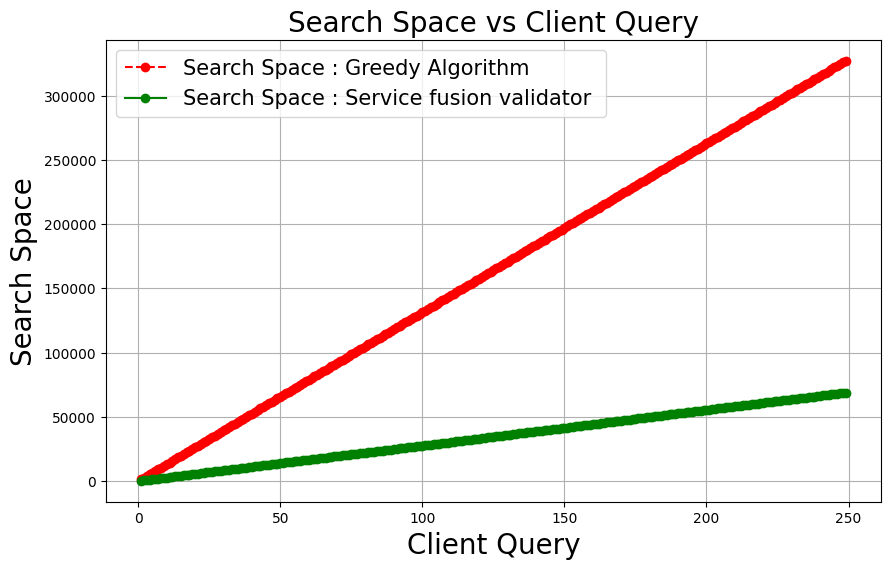

In [ ]:

# Plot cumulative execution time increasing with respect to search space
plt.figure(figsize=(10, 6))
plt.plot(client_query, cumulative_execution_time_greedy_model, linestyle='--',marker='o',label='Search Space : Greedy Algorithm', color='red')
plt.plot(client_query, cumulative_execution_time, linestyle='-',marker='o', label='Search Space : Service fusion validator ', color='green')
plt.title('Search Space vs Client Query', fontsize=20)
plt.xlabel('Client Query', fontsize=20)
plt.ylabel('Search Space', fontsize=20)
plt.legend(fontsize=15)
plt.grid()
plt.show()


**Composability Model**
---

In [ ]:
# The data is given in the form of .txt files. Here we convert the data into a .csv file
# and save it under the 'train' and 'test' directories for further use. Also the data here is
# arranged according to the subject ID. Therefore to break any correlation that may exists
# between the datapoints, we shuffle the dataset before dividing it into public and private
# datasets to be used in the Neural Network model.
features = []
with open("features.txt") as file:
    for line in file:
        features.append(line.split()[1])

# Renaming duplicate column names
names = []
count = {}
for feature in features:
    if(features.count(feature) > 1):
        names.append(feature)
for name in names:
    count[name] = features.count(name)

for i in range(len(features)):
    if(features[i] in names):
        num = count[features[i]]
        count[features[i]] -= 1;
        features[i] = str(features[i] + str(num))


train_df = pd.read_csv("X_train.txt", delim_whitespace = True,names= features)
train_df['subject_id'] = pd.read_csv("subject_train.txt",header= None,squeeze=True)
train_df["activity"] = pd.read_csv("y_train.txt", header = None, squeeze = True)
activity = pd.read_csv("y_train.txt", header = None, squeeze = True)
label_name = activity.map({1: "WALKING", 2:"WALKING_UPSTAIRS", 3:"WALKING_DOWNSTAIRS", 4:"SITTING", 5:"STANDING", 6:"LYING"})
train_df["activity_name"] = label_name
train_df.head()

<ipython-input-2-5a03bdb63387>:28: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  train_df['subject_id'] = pd.read_csv("subject_train.txt",header= None,squeeze=True)
<ipython-input-2-5a03bdb63387>:29: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  train_df["activity"] = pd.read_csv("y_train.txt", header = None, squeeze = True)
<ipython-input-2-5a03bdb63387>:30: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  activity = pd.read_csv("y_train.txt", header = None, squeeze = True)


,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject_id,activity,activity_name
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1,5,STANDING
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1,5,STANDING
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,1,5,STANDING
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,1,5,STANDING
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,1,5,STANDING


In [ ]:
test_df = pd.read_csv("X_test.txt", delim_whitespace = True, names = features)
test_df['subject_id'] = pd.read_csv("subject_test.txt",header= None,squeeze=True)
test_df["activity"] = pd.read_csv("y_test.txt", header = None, squeeze = True)
activity = pd.read_csv("y_test.txt", header = None, squeeze = True)
label_name = activity.map({1: "WALKING", 2:"WALKING_UPSTAIRS", 3:"WALKING_DOWNSTAIRS", 4:"SITTING", 5:"STANDING", 6:"LYING"})
test_df["activity_name"] = label_name
test_df.head()

<ipython-input-3-b9d94fb3fdd5>:2: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  test_df['subject_id'] = pd.read_csv("subject_test.txt",header= None,squeeze=True)
<ipython-input-3-b9d94fb3fdd5>:3: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  test_df["activity"] = pd.read_csv("y_test.txt", header = None, squeeze = True)
<ipython-input-3-b9d94fb3fdd5>:4: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  activity = pd.read_csv("y_test.txt", header = None, squeeze = True)


,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject_id,activity,activity_name
0,0.257178,-0.023285,-0.014654,-0.938404,-0.920091,-0.667683,-0.952501,-0.925249,-0.674302,-0.894088,...,0.006462,0.162920,-0.825886,0.271151,-0.720009,0.276801,-0.057978,2,5,STANDING
1,0.286027,-0.013163,-0.119083,-0.975415,-0.967458,-0.944958,-0.986799,-0.968401,-0.945823,-0.894088,...,-0.083495,0.017500,-0.434375,0.920593,-0.698091,0.281343,-0.083898,2,5,STANDING
2,0.275485,-0.026050,-0.118152,-0.993819,-0.969926,-0.962748,-0.994403,-0.970735,-0.963483,-0.939260,...,-0.034956,0.202302,0.064103,0.145068,-0.702771,0.280083,-0.079346,2,5,STANDING
3,0.270298,-0.032614,-0.117520,-0.994743,-0.973268,-0.967091,-0.995274,-0.974471,-0.968897,-0.938610,...,-0.017067,0.154438,0.340134,0.296407,-0.698954,0.284114,-0.077108,2,5,STANDING
4,0.274833,-0.027848,-0.129527,-0.993852,-0.967445,-0.978295,-0.994111,-0.965953,-0.977346,-0.938610,...,-0.002223,-0.040046,0.736715,-0.118545,-0.692245,0.290722,-0.073857,2,5,STANDING


# Saving train and test data to a resuable .csv file-

In [ ]:
train_df = shuffle(train_df)
test_df = shuffle(test_df)
train_df.to_csv("train.csv", index = False)
test_df.to_csv("test.csv", index = False)

NameError: name 'train_df' is not defined

# Loading the data from the .csv file-

In [ ]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
train_df = shuffle(train_df)
test_df = shuffle(test_df)
train_df['activity'] -= 1;
test_df['activity'] -= 1;

y_train = train_df['activity']
X_train = train_df.drop(['activity','activity_name','subject_id'],axis=1)
y_test = test_df['activity']
X_test = test_df.drop(['activity','activity_name','subject_id'],axis=1)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(7352, 561)
(2947, 561)
(7352,)
(2947,)


In [ ]:
X_test_additional=X_test[:1000]
y_test_additional=y_test[:1000]
print(X_test_additional.shape)
print(y_test_additional.shape)

(1000, 561)
(1000,)


In [ ]:
X_test_additional2=X_test[1000:2000]
y_test_additional2=y_test[1000:2000]
print(X_test_additional2.shape)
print(y_test_additional2.shape)

(1000, 561)
(1000,)


In [ ]:
X_test_additional3=X_test[2000:-1]
y_test_additional3=y_test[2000:-1]
print(X_test_additional3.shape)
print(y_test_additional3.shape)

(946, 561)
(946,)


# Global variables and Function declarations-

In [ ]:
# Variables-
epochs = 50
batch_size = 64
num_classes = 6
fig_size = (9,7)

In [ ]:
# FUNCTIONS-
def PREPROCESS(X , y):
    scaler = MinMaxScaler()
    scaler.fit(X)
    X = scaler.transform(X)
    y = np.array(y)
    return X,y

def CREATE_MODEL(input_shape):
    model = Sequential()
    model.add(Input(shape = input_shape,))
    model.add(Dense(256,activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64,activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32,activation='relu'))
    model.add(Dense(num_classes,activation='softmax'))
    return model

def COMPILE(model):
    model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
    )
    return model;

def FIT(model,X,y,i):
    history = model.fit(
    X,
    y,
    validation_split=0.2,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint(f'./model_{i}.h5', save_best_only=True),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.1,
            patience=1
        )
    ],
    verbose=0
    )
    return history,model

def PLOT(history,i):
    epochs_range = range(epochs)
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    print(train_acc[:-1])
    print(val_acc[:-1])

    plt.figure(figsize=fig_size)
    plt.plot(epochs_range,train_loss,label="Training Loss")
    plt.plot(epochs_range,val_loss,label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title(f"Model {i} - Loss Over Time")
    plt.show()

    plt.figure(figsize=fig_size)
    plt.plot(epochs_range,train_acc,label="Training accuracy")
    plt.plot(epochs_range,val_acc,label="Validation accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("accuracy")
    plt.legend()
    plt.title(f"Model {i} - Accuracy")
    plt.show()

def CONFUSION_MATRIX(y_test, y_pred):
    confusionMatrix = confusion_matrix(y_test, y_pred)
    sns.set(font_scale=1.5)
    labels = ["WALKING", "WALKING_UPSTAIRS", "WALKING_DOWNSTAIRS", "SITTING", "STANDING", "LYING"]
    plt.figure(figsize=(16,7))
    sns.heatmap(confusionMatrix, cmap = "Blues", annot = True, fmt = ".0f", xticklabels=labels, yticklabels=labels)
    plt.title("Global Model Confusion Matrix", fontsize = 30)
    plt.xlabel('Predicted Class', fontsize = 20)
    plt.ylabel('Original Class', fontsize = 20)
    plt.tick_params(labelsize = 15)
    plt.xticks(rotation = 45)
    plt.show()

def LOAD_MODELS():
    for i in range(1,4):
        model = load_model(f'./model_{i}.h5')
        all_models.append(model)

def APPLY_WEIGHT_FUNCTION(weights):
    avg_model_weights = []
    n_models = len(all_models)
    n_layers = len(all_models[0].get_weights())
    for layer in range(n_layers):
        layer_weights = np.array([model.get_weights()[layer] for model in all_models])
        avg_layer_weights = np.average(layer_weights, axis=0, weights=weights)
        avg_model_weights.append(avg_layer_weights)
    return avg_model_weights;

In [ ]:
import csv

def PLOT(history, i):
    epochs = len(history.history['accuracy'])
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']


    # Save data to CSV file
    with open(f'history_data_{i}.csv', 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['Epoch', 'Train Accuracy', 'Validation Accuracy','Train los', 'Validation los'])
        for epoch in range(epochs):
            writer.writerow([epoch+1, train_acc[epoch], val_acc[epoch],train_loss[epoch], val_loss[epoch]])

    # Remaining code for plotting
    fig, axs = plt.subplots(1, 5, figsize=(20, 5))
    # Plotting for each epoch
    for idx, epoch_value in enumerate([10, 20, 25, 35, 50]):
        plot_accuracy_subplot(axs[idx], epochs, train_acc, val_acc, i, epoch_value)
    plt.tight_layout()
    plt.show()


def plot_accuracy_subplot(ax, epochs, train_acc, val_acc, i, epoch_num):
    epochs_range = range(epoch_num)

    # Plot Accuracy
    ax.plot(epochs_range, train_acc[:epoch_num], label="Training Accuracy")
    ax.plot(epochs_range, val_acc[:epoch_num], label="Validation Accuracy")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Accuracy")
    ax.set_title(f"MLaaS {i} - Accuracy up to Epoch {epoch_num}")

    # Display legend only for the last subplot
    if epoch_num == 50:
        ax.legend()


# Model replica number-1

In [ ]:
# MODEL REPLICA NO.1
X_train_1 = X_train[0:2500]
y_train_1 = y_train[0:2500]

In [ ]:
# Add noise to the dataset
noise_level = 0.2 # Adjust the noise level as needed
X_train_1 = X_train_1 + np.random.normal(loc=0, scale=noise_level, size=X_train_1.shape)

X_train_1.shape

(2500, 561)

In [ ]:
X_train_1

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
4593,-0.056953,-0.482019,0.128604,-0.795519,-0.683905,-1.472600,-0.746647,-1.041931,-0.930838,-1.094744,...,0.399884,-0.895197,-1.256030,-0.066944,0.060818,0.671311,0.115327,-0.946498,0.292322,-0.233889
3265,0.535050,-0.096224,0.159540,-0.507051,-0.030044,-0.113828,-0.980258,-0.133671,-0.414628,-0.370039,...,-0.310015,0.239766,-0.565566,-0.571726,0.589825,1.071747,-0.557124,-1.267346,0.182425,-0.161663
4062,0.100586,0.060593,-0.155924,0.063634,0.040670,-0.134163,-0.390051,-0.004978,-0.030759,0.319776,...,0.394111,-0.307478,-0.481540,-0.300932,-0.854888,1.380674,-0.671624,-1.050662,0.328782,0.020003
3979,0.509029,-0.002021,-0.066124,0.384365,0.269673,-0.307574,0.206827,0.463114,-0.474971,0.240564,...,0.034394,-0.489913,-1.097357,-0.661786,-0.985132,0.613400,-0.921548,-0.596316,0.074425,-0.026705
7266,0.586230,-0.117528,0.321692,-1.412199,-1.117804,-0.721099,-1.045418,-0.698682,-1.120508,-0.885085,...,0.353411,-0.414489,-1.058230,0.372183,-0.565065,-0.409241,-0.378623,-0.573758,-0.136189,0.110753
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1521,0.116151,-0.012651,-0.031245,-1.048867,-0.900536,-1.000663,-0.751568,-1.201914,-1.436353,-1.140002,...,0.037840,-0.295269,-0.934919,-0.006468,0.227733,-0.190039,-0.165475,0.583529,-0.275684,-0.449027
1919,0.369266,0.416027,-0.376300,-1.051779,-1.174330,-1.043277,-1.011687,-1.033307,-1.124450,-1.330844,...,0.220582,-0.311940,-0.711414,0.499867,0.810480,0.280838,-0.343480,-0.697155,-0.204950,0.217953
1459,0.210470,-0.245692,-0.254657,-1.328537,-0.766358,-0.942218,-0.986621,-0.954117,-1.029994,-0.762348,...,-0.083099,-0.555049,-0.975458,-0.080383,0.540182,-0.020922,0.151103,-0.113797,0.127520,-0.216724
5456,0.435568,0.070215,-0.398338,-0.981022,-0.518163,-1.099092,-1.066176,-0.807909,-0.829080,-0.843694,...,-0.172746,-0.293268,-0.615626,-0.022589,0.315305,0.384535,0.017073,-1.037571,-0.073140,-0.023887


In [ ]:
X_train_1.shape

(2500, 561)

In [ ]:
X_train_1, y_train_1 = PREPROCESS(X_train_1,y_train_1);

In [ ]:
model_1 = CREATE_MODEL(X_train_1.shape[1]);
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               143872    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 32)                2

In [ ]:
model_1 = COMPILE(model_1)
history_1,model_1 = FIT(model_1,X_train_1,y_train_1,1)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


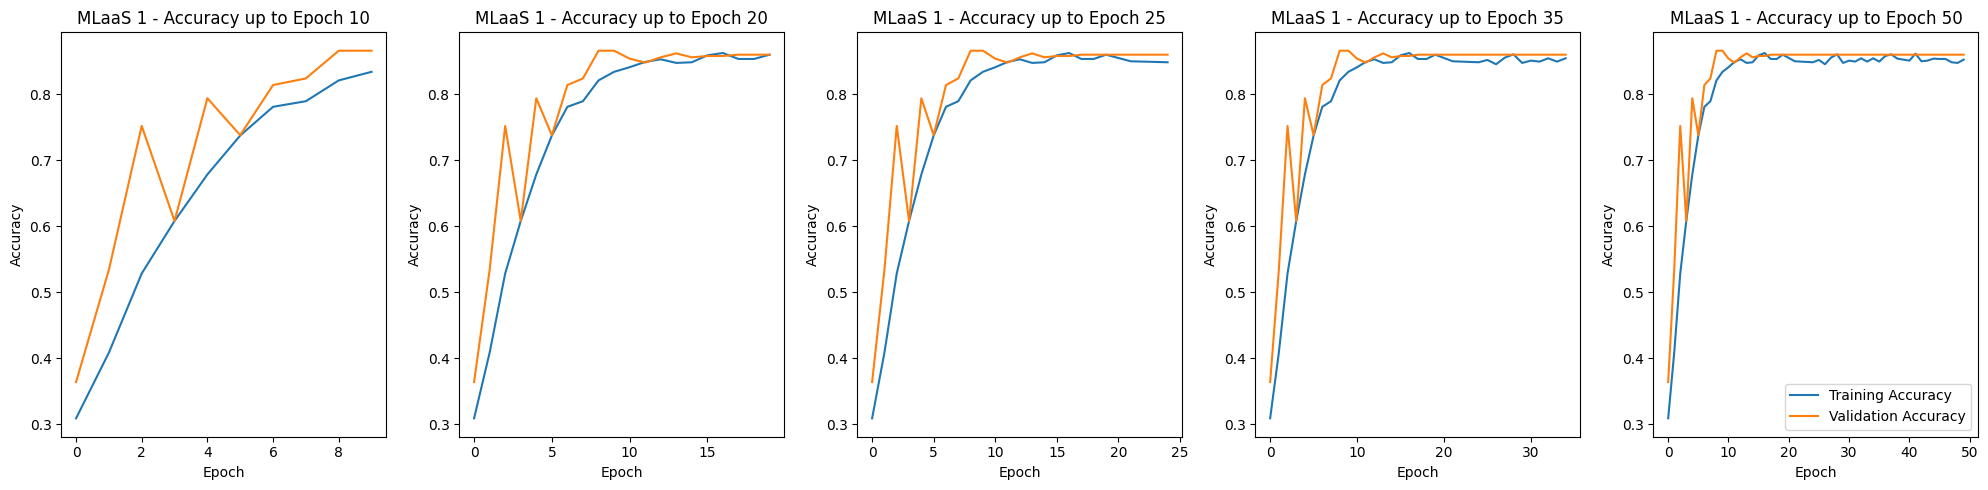

In [ ]:
PLOT(history_1, 1)

In [ ]:
history_1.history['accuracy']

[0.3089999854564667,
 0.40849998593330383,
 0.5285000205039978,
 0.6079999804496765,
 0.6784999966621399,
 0.737500011920929,
 0.781000018119812,
 0.7894999980926514,
 0.8209999799728394,
 0.8339999914169312,
 0.8410000205039978,
 0.8489999771118164,
 0.8529999852180481,
 0.8475000262260437,
 0.8485000133514404,
 0.859000027179718,
 0.862500011920929,
 0.8535000085830688,
 0.8535000085830688,
 0.8600000143051147,
 0.8550000190734863,
 0.8500000238418579,
 0.8495000004768372,
 0.8489999771118164,
 0.8485000133514404,
 0.8519999980926514,
 0.8454999923706055,
 0.8554999828338623,
 0.8604999780654907,
 0.8475000262260437,
 0.8510000109672546,
 0.8495000004768372,
 0.8544999957084656,
 0.8495000004768372,
 0.8544999957084656,
 0.8495000004768372,
 0.8579999804496765,
 0.8604999780654907,
 0.8539999723434448,
 0.8525000214576721,
 0.8510000109672546,
 0.8615000247955322,
 0.8500000238418579,
 0.8510000109672546,
 0.8539999723434448,
 0.8535000085830688,
 0.8535000085830688,
 0.8485000133514

# Model replica number-2

In [ ]:
# MODEL REPLICA NO.2
X_train_2 = X_train[2500:5000]
y_train_2 = y_train[2500:5000]

In [ ]:
# Add noise to the dataset
noise_level = 0.4 # Adjust the noise level as needed
X_train_2 = X_train_2 + np.random.normal(loc=0, scale=noise_level, size=X_train_1.shape)

X_train_2.shape

(2500, 561)

In [ ]:
X_train_2, y_train_2 = PREPROCESS(X_train_2,y_train_2)

In [ ]:
model_2 = CREATE_MODEL(X_train_2.shape[1])
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 256)               143872    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 32)               

In [ ]:
model_2 = COMPILE(model_2)
history_2,model_2 = FIT(model_2,X_train_2,y_train_2,2);

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


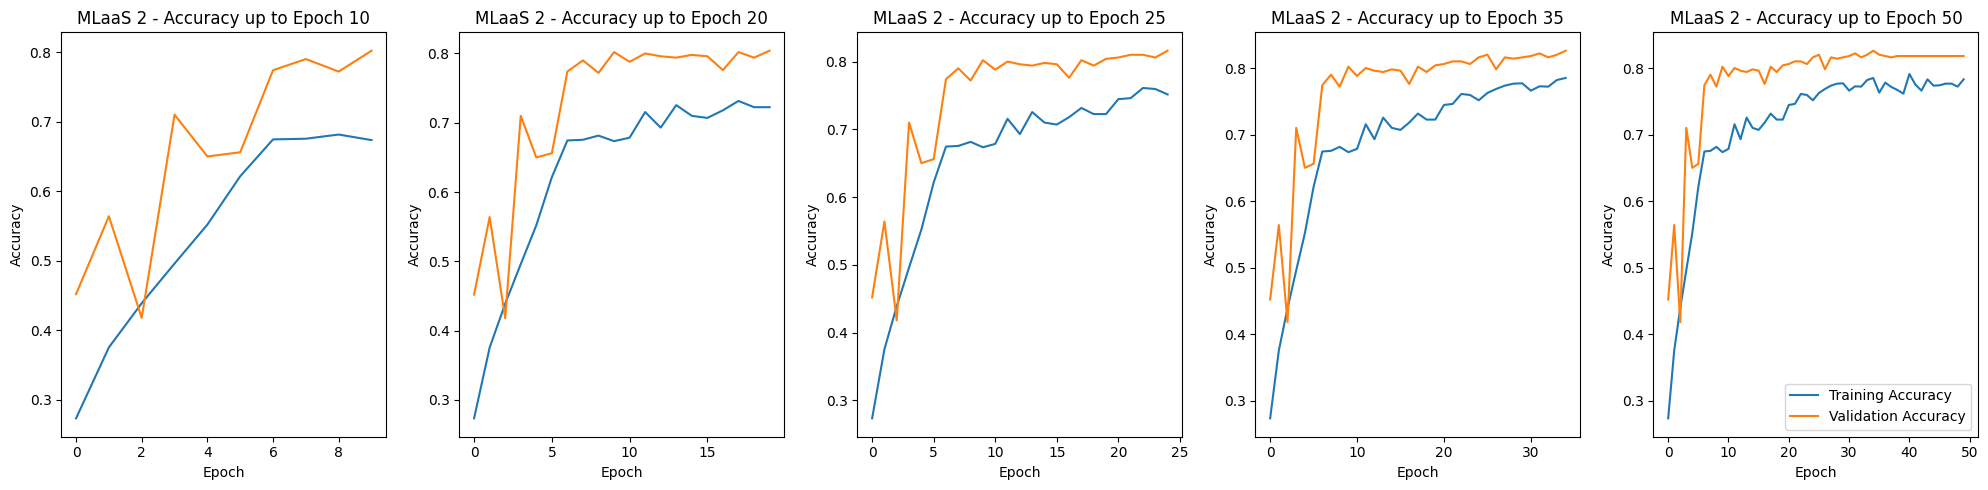

In [ ]:
PLOT(history_2,2);

# Model replica number-3

In [ ]:
# MODEL REPLICA NO.3
X_train_3 = X_train[5000:-1]
y_train_3 = y_train[5000:-1]

In [ ]:
X_train_3, y_train_3 = PREPROCESS(X_train_3,y_train_3)

In [ ]:
model_3 = CREATE_MODEL(X_train_3.shape[1])
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 256)               143872    
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_11 (Dense)            (None, 128)               32896     
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_12 (Dense)            (None, 64)                8256      
                                                                 
 dropout_8 (Dropout)         (None, 64)                0         
                                                                 
 dense_13 (Dense)            (None, 32)               

In [ ]:
model_3 = COMPILE(model_3);
history_3, model_3 = FIT(model_3,X_train_3,y_train_3,3)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


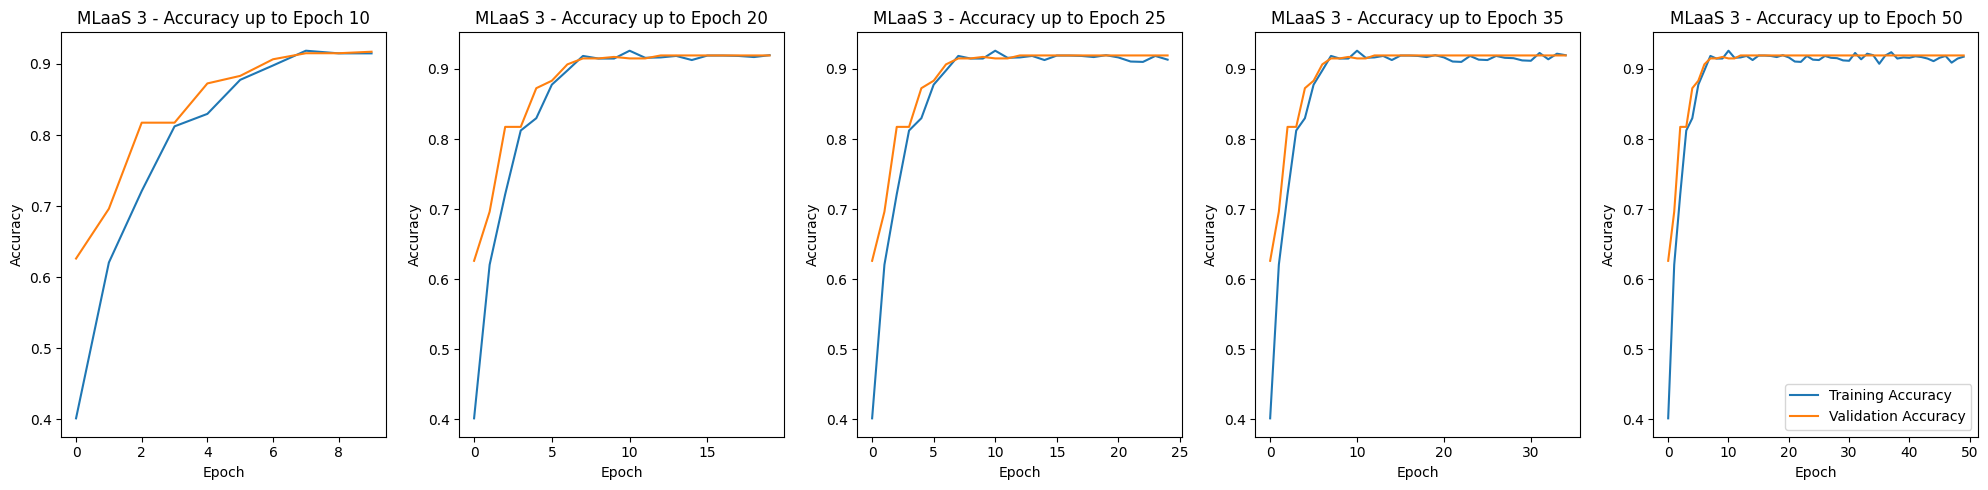

In [ ]:
PLOT(history_3,3)

# The global model

In [ ]:
X_test, y_test = PREPROCESS(X_test, y_test)

In [ ]:
model_g = CREATE_MODEL(X_test.shape[1])
model_g.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 256)               143872    
                                                                 
 dropout_9 (Dropout)         (None, 256)               0         
                                                                 
 dense_16 (Dense)            (None, 128)               32896     
                                                                 
 dropout_10 (Dropout)        (None, 128)               0         
                                                                 
 dense_17 (Dense)            (None, 64)                8256      
                                                                 
 dropout_11 (Dropout)        (None, 64)                0         
                                                                 
 dense_18 (Dense)            (None, 32)               

In [ ]:
all_models = []
LOAD_MODELS()

In [ ]:
weights = [max(history_1.history['accuracy']), max(history_2.history['accuracy']), max(history_3.history['accuracy'])]
x = max(weights)
idx = weights.index(x)
weights[idx] = 1
x = min(weights)
idx = weights.index(x)
weights[idx] = 0.02
for i in range(3):
    if(weights[i] != 1 and weights[i] != 0.02):
        weights[i] = 0.03
        break
avg_model_weights = APPLY_WEIGHT_FUNCTION(weights)

In [ ]:
model_g.set_weights(avg_model_weights)
model_g = COMPILE(model_g)
_ , accuracy = model_g.evaluate(X_test,y_test,verbose=0)
print(f"Global Model Accuracy: {round(accuracy*100,2)}%")
c1=round(accuracy*100,2)

Global Model Accuracy: 88.46%


In [ ]:
_ , loss = model_g.evaluate(X_test,y_test,verbose=0)
print(f"Global Model Accuracy: {round(loss *100,2)}%")

Global Model Accuracy: 87.61%


In [ ]:
X_test_additional, y_test1 = PREPROCESS(X_test_additional, y_test_additional)
X_test_additional2, y_test2 = PREPROCESS(X_test_additional2, y_test_additional2)
X_test_additional3, y_test3 = PREPROCESS(X_test_additional3, y_test_additional3)

**Client 1 After composition**

In [ ]:
model_g.set_weights(avg_model_weights)
model_g = COMPILE(model_g)
_ , accuracy = model_g.evaluate(X_test_additional,y_test1,verbose=0)
print(f"Global Model Accuracy: {round(accuracy*100,2)}%")
c2=round(accuracy*100,2)

Global Model Accuracy: 84.0%


**Client 2 After composition**

In [ ]:
model_g.set_weights(avg_model_weights)
model_g = COMPILE(model_g)
_ , accuracy = model_g.evaluate(X_test_additional2,y_test2,verbose=0)
print(f"Global Model Accuracy: {round(accuracy*100,2)}%")
c3=round(accuracy*100,2)

Global Model Accuracy: 90.3%


**Client 3 After composition**

In [ ]:
model_g.set_weights(avg_model_weights)
model_g = COMPILE(model_g)
_ , accuracy = model_g.evaluate(X_test_additional3,y_test3,verbose=0)
print(f"Global Model Accuracy: {round(accuracy*100,2)}%")
c3=round(accuracy*100,2)

Global Model Accuracy: 88.79%


In [ ]:
X_test_additional

array([[0.68602884, 0.56612192, 0.51220213, ..., 0.11814181, 0.59686896,
        0.55255883],
       [0.80236232, 0.62734913, 0.53535989, ..., 0.1556684 , 0.62598987,
        0.5505798 ],
       [0.63563645, 0.56691154, 0.60357972, ..., 0.08780206, 0.58345185,
        0.53635466],
       ...,
       [0.68457336, 0.56538836, 0.5124359 , ..., 0.8531724 , 0.11572175,
        0.33426571],
       [0.68696845, 0.56826464, 0.51112831, ..., 0.79065849, 0.09512054,
        0.36570537],
       [0.69421859, 0.56760911, 0.51087728, ..., 0.83500074, 0.2212122 ,
        0.22601408]])

In [ ]:
max(history_1.history['accuracy'])

0.862500011920929

In [ ]:
max(history_2.history['accuracy'])

0.7910000085830688

In [ ]:
max(history_3.history['accuracy'])

0.9260638356208801

In [ ]:
y_pred = model_g.predict(X_test)
y_pred = np.argmax(y_pred,axis=1)

93/93 [==============================] - 0s 2ms/step


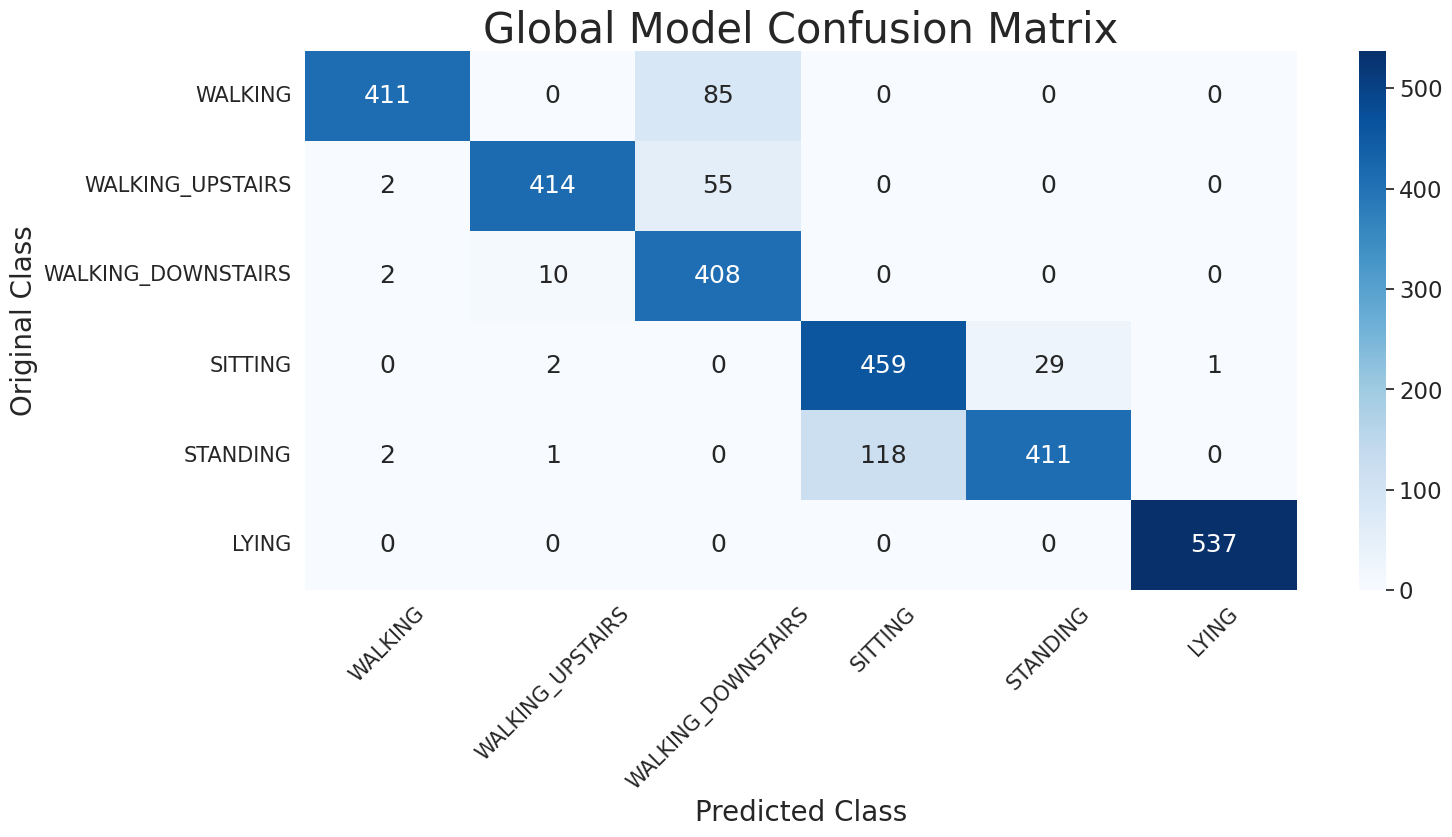

In [ ]:
CONFUSION_MATRIX(y_test,y_pred)

**Before Composition**

---



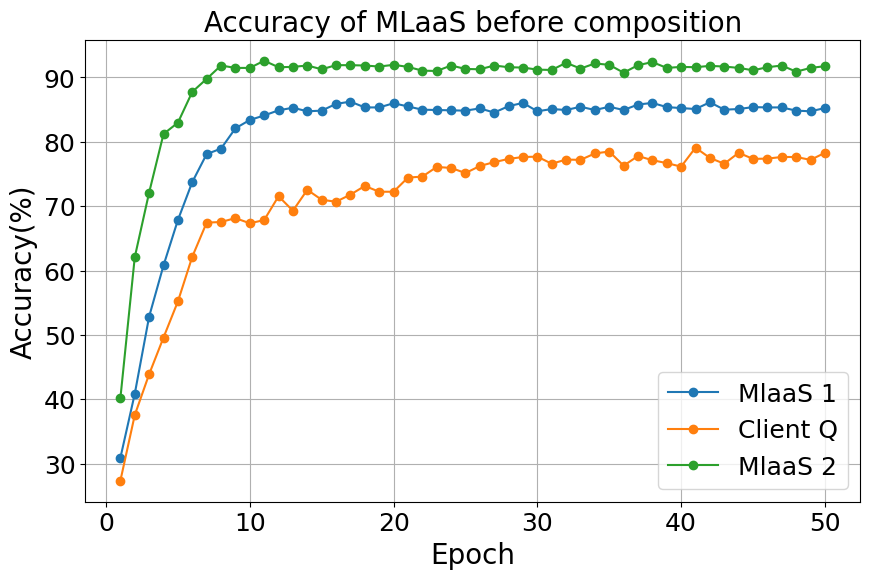

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Read data from CSV files
df1 = pd.read_csv('history_data_1.csv')
df2 = pd.read_csv('history_data_2.csv')
df3 = pd.read_csv('history_data_3.csv')

df1=df1[:50]
df2=df2[:50]
df3=df3[:50]
# Plotting the data
plt.figure(figsize=(10, 6))

# Plot data for Model 1
plt.plot(df1['Epoch'], df1['Train Accuracy']*100,marker='o', linestyle='-', label='MlaaS 1')

# Plot data for Model 2
plt.plot(df2['Epoch'], df2['Train Accuracy']*100, marker='o', linestyle='-',label='Client Q')

# Plot data for Model 3
plt.plot(df3['Epoch'], df3['Train Accuracy']*100,marker='o', linestyle='-', label='MlaaS 2')

# Adding labels and title with increased font size
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Accuracy(%)', fontsize=20)
plt.title('Accuracy of MLaaS before composition', fontsize=20)

# Increasing font size of x-axis ticks
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
# Adding legend
plt.legend(fontsize=18)

# Display the plot
plt.grid(True)
plt.show()


<ipython-input-89-86126d9389db>:21: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.xlim(51, max(df1['Epoch']))  # Adjust the maximum epoch value from df1 or any other dataframe


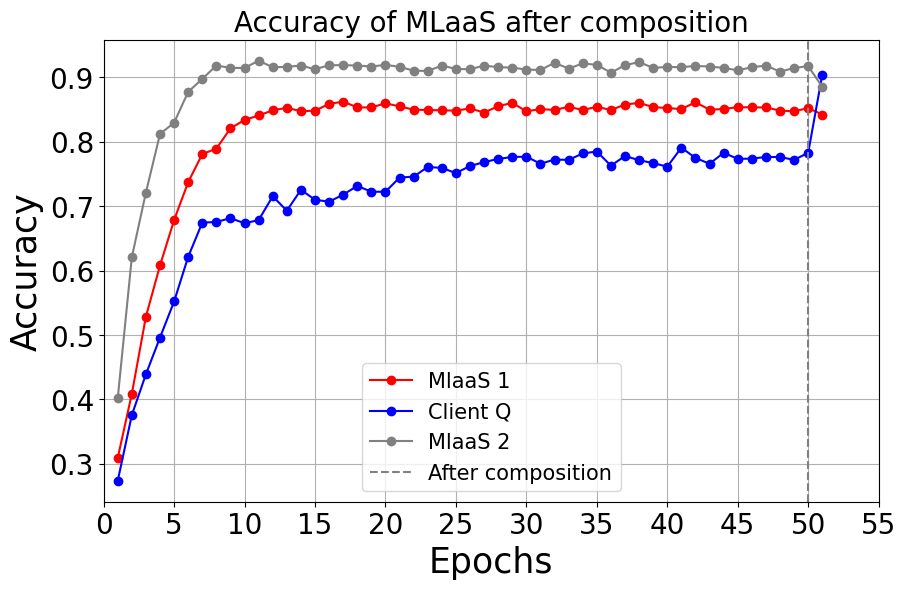

In [ ]:
import matplotlib.pyplot as plt

# Plotting the data
plt.figure(figsize=(10, 6))

# Plot data for Model 1
plt.plot(df1['Epoch'], df1['Train Accuracy'], marker='o', linestyle='-', label='MlaaS 1',color='red')

# Plot data for Model 2
plt.plot(df2['Epoch'], df2['Train Accuracy'], marker='o', linestyle='-', label='Client Q',color='blue')

# Plot data for Model 3
plt.plot(df3['Epoch'], df3['Train Accuracy'], marker='o', linestyle='-', label='MlaaS 2',color='grey')

# Adding labels and title
plt.xlabel('Epochs', fontsize=25)
plt.ylabel('Accuracy', fontsize=25)
plt.title('Accuracy of MLaaS after composition', fontsize=20)

# Set x-axis limits to include epoch 51 and beyond
plt.xlim(51, max(df1['Epoch']))  # Adjust the maximum epoch value from df1 or any other dataframe
# Alternatively, if you want to zoom out from epoch 50, you can set plt.xlim(1, max(df1['Epoch']))

# Increase font size of x-axis ticks
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Add a tick at epoch 51
plt.xticks([51])
# Set tick positions for x-axis
tick_positions = list(range(0, max(df1['Epoch']) + 5, 5))  # Include epoch 51 along with other epochs
plt.xticks(tick_positions)

# Adding a vertical dotted line at epoch 50
plt.axvline(x=50, color='gray', linestyle='--', label='After composition')

# Adding legend
plt.legend(fontsize=15)

# Display the plot
plt.grid(True)
plt.show()


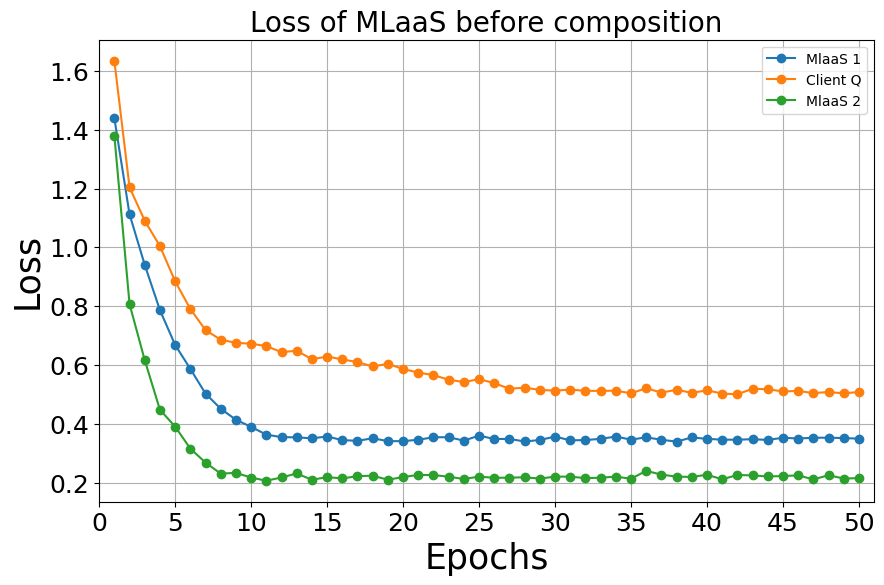

In [ ]:
import matplotlib.pyplot as plt

# Plotting the data
plt.figure(figsize=(10, 6))
# Read data from CSV files
df1 = pd.read_csv('history_data_1.csv')
df2 = pd.read_csv('history_data_2.csv')
df3 = pd.read_csv('history_data_3.csv')


# Plot data for Model 1
plt.plot(df1['Epoch'], df1['Train los'], marker='o', linestyle='-', label='MlaaS 1')

# Plot data for Model 2
plt.plot(df2['Epoch'], df2['Train los'], marker='o', linestyle='-', label='Client Q')

# Plot data for Model 3
plt.plot(df3['Epoch'], df3['Train los'], marker='o', linestyle='-', label='MlaaS 2')

# Adding labels and title
plt.xlabel('Epochs', fontsize=25)
plt.ylabel('Loss', fontsize=25)
plt.title('Loss of MLaaS before composition', fontsize=20)

# Set x-axis limits to include epoch 51
plt.xlim(1, 51)

# Increase font size of x-axis ticks
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

# Set tick positions for x-axis
tick_positions = list(range(0, 52, 5))  # Include epoch 51 along with other epochs at intervals of 4
plt.xticks(tick_positions)


# Adding legend
plt.legend()

# Display the plot
plt.grid(True)
plt.show()
